In [1]:
# load helper functions
%run MB_thresholding_helper_functions.py

In [2]:
# data loading
expt_name = 'EMD-LMNB1_MCF7' # name of experiment folder

# replace /path/to/folder/ below with path to experiment folder
dir_path = '/path/to/folder/'
root_dir = dir_path + expt_name + '/'

name_anti1 = 'EMD' # Mouse antibody
name_anti2 = 'LMNB1' # Rabbit antibody
name_dual = 'EMD-LMNB1'

# intensity measure on which to base thresholding
intensity = 'IntegratedIntensity'

# the user should add the three csv files read in below to the experiment folder
cells_df = pd.read_csv(root_dir + 'EMD-LMNB1_MCF7_Both_Cells.csv', decimal='.', sep=",")
blobs_df = pd.read_csv(root_dir + 'EMD-LMNB1_MCF7_BlobsInCells.csv', decimal='.', sep=",")
image_df = pd.read_csv(root_dir + 'EMD-LMNB1_MCF7_Image.csv', decimal='.', sep=",")

# note: if any of the three file shapes below have only one column it mean the csv was saved with a ',' for the decimal
print('cells df shape = ' + str(cells_df.shape))
print('blobs df shape = ' + str(blobs_df.shape))
print('image df shape = ' + str(image_df.shape))

cells df shape = (180588, 9)
blobs df shape = (180588, 56)
image df shape = (28, 176)


In [3]:
# extract required metadata
meta = image_df[['ImageNumber', 'Metadata_Exp', 'Metadata_Slide', 'Metadata_Well']]
meta

,ImageNumber,Metadata_Exp,Metadata_Slide,Metadata_Well
0,1,BX4133,1,A2
1,2,BX4133,1,A2
2,3,BX4133,1,A2
3,4,BX4133,1,B2
4,5,BX4133,1,B2
5,6,BX4133,1,B2
6,7,BX4133,2,A2
7,8,BX4133,2,A2
8,9,BX4133,2,A2
9,10,BX4133,2,B2


In [4]:
# checking image numbers in cells and blobs dataframes match those in the metadata
print(set(blobs_df['ImageNumber']))
print(set(cells_df['ImageNumber']))

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}
{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28}


In [5]:
# extracting image numbers for each staining condition
# 'anti1' = antibody 1 (Mouse)
# 'anti2' = antibody 2 (Rabbit)
# 'dual' = both antibodies

# for layouts across multiple experiments and slides the user should create a small layout csv
# from this the image numbers from the CellProfiler output can be extracted from 'meta'
layout = pd.read_csv(root_dir + 'EMD-LMNB1_MCF7_layout.csv', decimal='.', sep=",")
layout

,stain,exp,slide,well
0,anti1,BX4133,1,A2
1,anti1,BX4133,1,B2
2,anti1,BX4141,1,A1
3,anti2,BX4133,2,A2
4,anti2,BX4133,2,B2
5,anti2,BX4141,1,B3
6,dual,BX4133,3,A2
7,dual,BX4133,3,B2
8,dual,MM0000,1,A2


In [6]:
imnum_anti1 = []
imnum_anti2 = []
imnum_dual = []

for i in range(len(layout)):
    temp = meta.loc[(meta['Metadata_Exp'] == layout.iloc[i]['exp']) &
                    (meta['Metadata_Slide'] == layout.iloc[i]['slide']) &
                    (meta['Metadata_Well'] == layout.iloc[i]['well'])]
    
    if layout.iloc[i]['stain'] == 'anti1':
        imnum_anti1 = np.append(imnum_anti1, temp['ImageNumber'].values)
    
    if layout.iloc[i]['stain'] == 'anti2':
        imnum_anti2 = np.append(imnum_anti2, temp['ImageNumber'].values)
    
    if layout.iloc[i]['stain'] == 'dual':
        imnum_dual = np.append(imnum_dual, temp['ImageNumber'].values)

imnum_anti1 = imnum_anti1.astype(int)
imnum_anti2 = imnum_anti2.astype(int)
imnum_dual = imnum_dual.astype(int)

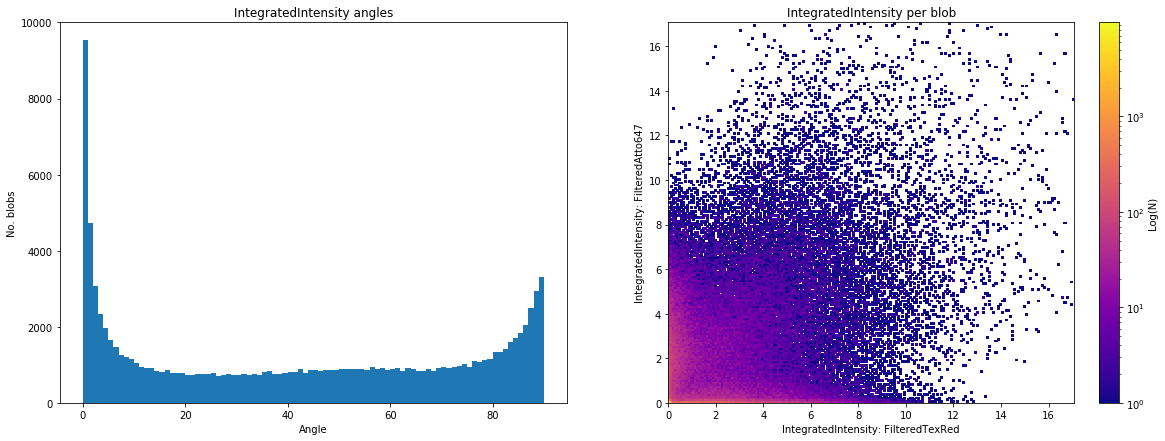

In [7]:
# extracting dual stained cells and plotting for determining thresholds
blobs_dual = blobs_df.loc[blobs_df['ImageNumber'].isin(list(imnum_dual))]
cells_dual = cells_df.loc[cells_df['ImageNumber'].isin(list(imnum_dual))]
x_dual = blobs_dual['Intensity_' + intensity + '_FilteredTexRed'].reset_index(drop=True)
y_dual = blobs_dual['Intensity_' + intensity + '_FilteredAtto647'].reset_index(drop=True)
angles_dual = compute_angles(x_dual, y_dual)
plotter_initial(x_dual, y_dual, angles_dual, intensity, bins=90)

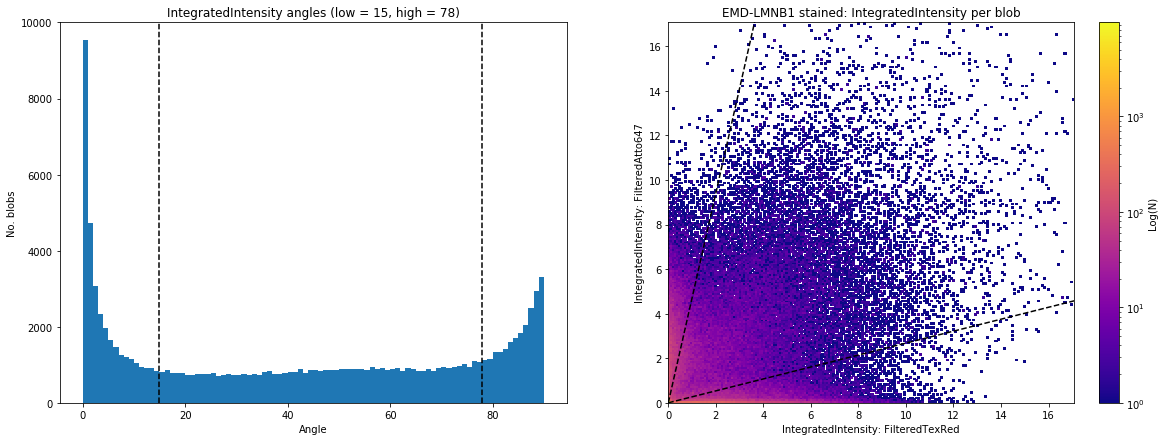

In [8]:
# setting thresholds for dual stained cells
low = 15
high = 78
plotter_thresholds(x_dual, y_dual, angles_dual, intensity, bins=90, low=low, high=high,
                   name=name_dual, dir_path=dir_path, expt_name=expt_name)

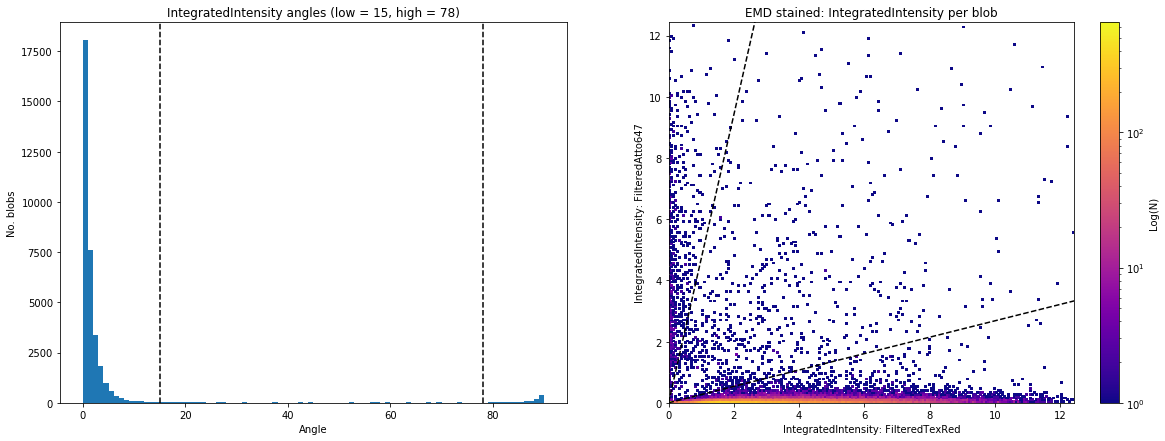

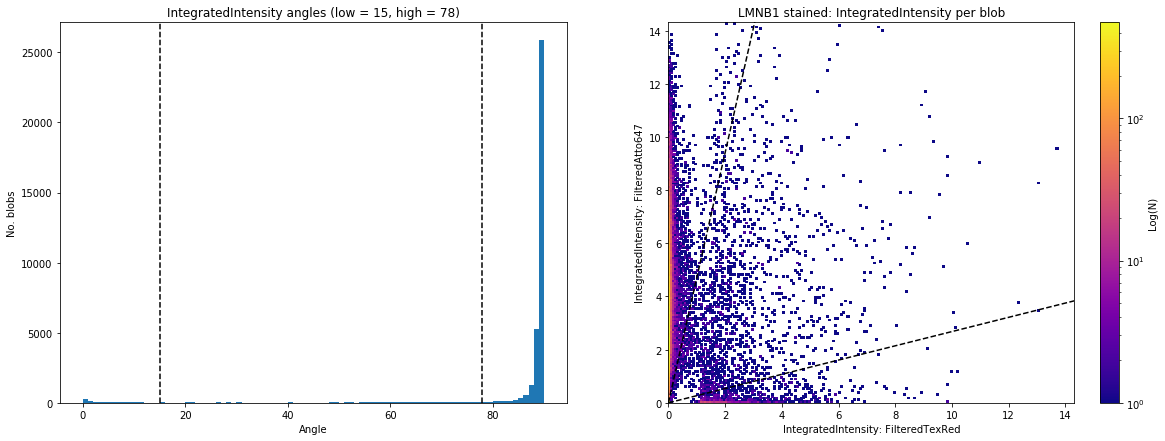

In [9]:
# making dual dataframe, based on thresholds set above
dual_df = df_maker_cells(angles_dual, cells_dual, condition=name_dual, low=low, high=high)

# applying dual set thresholds to the individually stained cases
blobs_anti1 = blobs_df.loc[blobs_df['ImageNumber'].isin(list(imnum_anti1))]
cells_anti1 = cells_df.loc[cells_df['ImageNumber'].isin(list(imnum_anti1))]
x_anti1 = blobs_anti1['Intensity_' + intensity + '_FilteredTexRed'].reset_index(drop=True)
y_anti1 = blobs_anti1['Intensity_' + intensity + '_FilteredAtto647'].reset_index(drop=True)
angles_anti1 = compute_angles(x_anti1, y_anti1)
plotter_thresholds(x_anti1, y_anti1, angles_anti1, intensity, bins=90, low=low, high=high,
                   name=name_anti1, dir_path=dir_path, expt_name=expt_name)
anti1_df = df_maker_cells(angles_anti1, cells_anti1, condition=name_anti1, low=low, high=high)

blobs_anti2 = blobs_df.loc[blobs_df['ImageNumber'].isin(list(imnum_anti2))]
cells_anti2 = cells_df.loc[cells_df['ImageNumber'].isin(list(imnum_anti2))]
x_anti2 = blobs_anti2['Intensity_' + intensity + '_FilteredTexRed'].reset_index(drop=True)
y_anti2 = blobs_anti2['Intensity_' + intensity + '_FilteredAtto647'].reset_index(drop=True)
angles_anti2 = compute_angles(x_anti2, y_anti2)
plotter_thresholds(x_anti2, y_anti2, angles_anti2, intensity, bins=90, low=low, high=high,
                   name=name_anti2, dir_path=dir_path, expt_name=expt_name)
anti2_df = df_maker_cells(angles_anti2, cells_anti2, condition=name_anti2, low=low, high=high)

In [10]:
# save final dataframe for plotting in R
final_df = pd.concat([dual_df, anti1_df, anti2_df], ignore_index=True, sort=False)
final_df.to_csv(dir_path + expt_name + '_' + intensity + '.csv', index=False)